#New way of accessing the API, some data processing with Garissa Data

#  NDVI Image Analysis and Mapping (of Garissa County) with Sentinel-2 and OpenEO API

This notebook outlines a comprehensive end-to-end process to access, process, and visualize NDVI imagery using Sentinel-2 data and the OpenEO platform.

---

##  Mount Google Drive and Install Required Packages
Similarly, a person's Google Drive is mounted.
Next, all packages and installations of required libraries such as `openeo`, `openeo-extra-spectral-indices`, `rasterio`, and `scipy` are made.

---

##  Connect to the OpenEO Copernicus Dataspace API
Establishes an authenticated session using OIDC credentials to access Copernicus Earth Observation data. The connection is established by calling:
```python
openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
```

Make sure to follow the instructions when you run the cell and wait for the entire cell to finish running. The output should clearly indicate proper authorization.

---

##  Define Geographic Area of Interest (AOI)
We need to defines a bounding box using geographic coordinates using an extent variable. This includes specifically finding a geographic center and sizing a bounding box around a specific latitude and longitude (e.g., Garissa).

We attempt to convert the AOI into a `MultiPolygon` using Shapely for spatial operations via :
```python
from shapely.geometry import Polygon, MultiPolygon
```

---

##  Define Cloud-Free NDVI Selection Function
Next, we notice that many of the images from Copernicus have high cloud coverage. Thus, we find the Best Available Pixel (BAP) using Sentinel-2's Scene Classification Layer (SCL) to filter clouds, shadows, and noise.

Within the function that does this, we apply a Gaussian smoothing kernel and morphological mask to reduce noisy cloud detection. This function can be called using the following format:
```python
def getBAP(scl, data, reducer="first/last"):
```  

---

##  Load and Filter Sentinel-2 Pre-Time frame
Using the Sentinel API, load Sentinel-2 Level 2A bands (`B04`, `B08`, `B12`) and the `SCL` layer for cloud masking. Using the proper bands correpsonding to Red and Near Infared Red (B08 and B04) NDVI is computed and filtered to retain only the clearest pixels.

---

##  Load and Filter Sentinel-2 Post-Time frame
Next, repeats the same procedure for a post-event time window. NDVI is computed again for this later period and cloud-free mosaics are generated.

---

##  NDVI Change Detection and Normalization
Next, we want to calculate NDVI difference between pre and post periods.
```python
ndvi_all = ndvi_pre - ndvi_post
```

Also, mormalize both NDVI arrays to a [0, 1] range. Then average them into a single image displaying an "average" for a time zone.

---

##  Save and Display NDVI Results
The outputs of these can be stored in `.tiff` files for pre, post, and combined NDVI data. Notice, the post file is the clearest. Thus it is used for later analysis. These tiffs are as follows:

`NDVI.tiff`, `Post_NDVI.tiff`, `city_radius.tiff`: pre-time, post-time, and difference.

Additionally the normalized average tiff is stored as: `city_radius_normalized_avg.tiff`

Additionally, `rasterio` and `matplotlib` are used to visualize all images with colorbars and grid overlays for easy interpretation.

---

##  Interactive Mapping with Folium
The python package `folium` is used to display the bounding box on an interactive map via HTML. With `folium` an overlay of NDVI data is possible as a semi-transparent PNG layer over a street map. Additionally, we include a second map with interactive lat/lon popups on click.

We generate the following htmls which are downloadable and can be access by pasting into your browswer:
- `bounding_box_map.html`: Static map showing AOI.
- `map_with_overlay.html`: Map showing NDVI overlay.
- `map_with_overlay_and_latlng.html`: NDVI overlay with interactive coordinates.




In [ ]:
#mounting the google drive to the workspace
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#installation and importing all proper packages
import scipy
import numpy as np
%pip install openeo
%pip install openeo-extra-spectral-indices
%pip install rasterio

import openeo
from openeo.extra.spectral_indices import compute_indices

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import rasterio
from rasterio.plot import show

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.4 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
ERROR: Could not find a version that satisfies the requirement openeo-extra-spectral-indices (from versions: none)
ERROR: No matching distribution found for openeo-extra-spectral-indices
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.8 MB/s eta 0:00:00


##To use openeo to connect to the API, you must have a registered account with Copernicus. Additionally, you must create an instance to access the data. This should generate a client key and secret key, both which are nessecary to access and pull data from the API.

In [ ]:
#this cell connects the API
#follow the authorization link when this line is run
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=AZEA-FQUH 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [ ]:
#defining the spatial coordinates of the area you want to analyze
extent = {"west": 0.99, "south": 2.03, "east": 38.67, "north": 41.58}

In [ ]:
#there may be some difficulty getting the correct size of a bbox, this code should allow you to reduce the dimensions
import math

# Calculate the center of the bounding box
lat_center = (extent["north"] + extent["south"]) / 2
lon_center = (extent["east"] + extent["west"]) / 2

# Calculate the diagonal distance (radius) between two opposite corners of the box
lat_diff = extent["north"] - extent["south"]
lon_diff = extent["east"] - extent["west"]

# Approximate radius of Earth in kilometers
earth_radius = 6371.0

# Convert the differences from degrees to kilometers
lat_diff_km = lat_diff * (earth_radius * math.pi / 180)
lon_diff_km = lon_diff * (earth_radius * math.pi / 180) * math.cos(math.radians(lat_center))

# Diagonal distance (radius) in kilometers
radius_km = math.sqrt(lat_diff_km**2 + lon_diff_km**2) / 2  # Divide by 2 to get the radius

# Now we have the reduced form: a center point and radius
reduced_extents = {
    "center_lat": lat_center,
    "center_lon": lon_center,
    "radius_km": radius_km
}



In [ ]:
#this code allows a user to specify a single poin (lat, long) and create a bounding box centered around that point
import math

# Center point (latitude, longitude)
center_lat = -0.083333
center_lon = 39.116

# Maximum size in meters (20 km x 20 km)
max_size_meters = 20000

# Conversion factors
meters_per_degree_lat = 111320  # Meters per degree of latitude
meters_per_degree_lon = 111320 * math.cos(math.radians(center_lat))  # Adjusted for the center latitude

# Calculate the size in degrees
lat_diff_deg = max_size_meters / meters_per_degree_lat  # Difference in latitude
lon_diff_deg = max_size_meters / meters_per_degree_lon  # Difference in longitude

# Calculate the bounding box coordinates
bounding_box = {
    "west": center_lon - (lon_diff_deg / 2),
    "south": center_lat - (lat_diff_deg / 2),
    "east": center_lon + (lon_diff_deg / 2),
    "north": center_lat + (lat_diff_deg / 2)
}

# Output the bounding box
print("Bounding Box Coordinates:")
print(f"West: {bounding_box['west']}")
print(f"South: {bounding_box['south']}")
print(f"East: {bounding_box['east']}")
print(f"North: {bounding_box['north']}")


Bounding Box Coordinates:
West: 39.02616878748726
South: -0.1731641174991017
East: 39.20583121251274
North: 0.006498117499101688


In [ ]:
#reducing the size of the bbox, attempt to create a multipolygon

#Defining your bounding box extents or coordinates centered around a specific point
extents = [
  {
    "west": center_lon - (lon_diff_deg / 2),
    "south": center_lat - (lat_diff_deg / 2),
    "east": center_lon + (lon_diff_deg / 2),
    "north": center_lat + (lat_diff_deg / 2)
}
]



# this creates a function to create MultiPolygon from the given extents
from shapely.geometry import Polygon, MultiPolygon

def create_multipolygon(extents):
    polygons = []
    for extent in extents:
        polygon_points = [
            (extent["west"], extent["south"]),
            (extent["west"], extent["north"]),
            (extent["east"], extent["north"]),
            (extent["east"], extent["south"]),
        ]
        polygons.append(Polygon(polygon_points))
    return MultiPolygon(polygons)


# save as a new extent to specify the shape using the function above
reduced_extent = create_multipolygon(extents)


In [ ]:
# define a function to identify cloud-free pixels in the available data-cube
#taken/adpated from the documentation detailing the usage of Sentinel-2 package

def getBAP(scl, data, reducer="first"):
    mask = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10)

    # mask is a bit noisy, so we apply smoothening
    # 2D gaussian kernel
    g = scipy.signal.windows.gaussian(11, std=1.6)
    kernel = np.outer(g, g)
    kernel = kernel / kernel.sum()

    # Morphological dilation of mask: convolution + threshold
    mask = mask.apply_kernel(kernel)
    mask = mask > 0.1

    data_masked = data.mask(mask)

    # now select Best Available Pixel (BAP) based on the mask
    return data_masked.reduce_dimension(reducer=reducer, dimension="t")

In [ ]:
#this cell connects and pulls specific bands and the data from the API
# loading S2 pre-collection by pulling from the API
s2pre = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-05-03", "2020-05-20"],
    spatial_extent=reduced_extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=30,
)

#the scl layer is part of the api which identifies different parts of the image (scene classification layer)
#this layer captures water, cloud, land etc
s2pre_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-05-03", "2020-05-20"],
    spatial_extent=reduced_extent,
    bands=["SCL"],
    max_cloud_cover=30,
)

# calculate ndvi
ndvi_pre = s2pre.ndvi()
# Instead of synchronous download, request an asynchronous job
# Request NDVI calculation asynchronously

In [ ]:
# Create a cloud free mosiac by calling the BAP function
ndvi_pre = getBAP(s2pre_scl, ndvi_pre, reducer="last")

In [ ]:
#downloading the NDVI data and saving it as a Tiff image
ndvi_pre.download("NDVI.tiff")

In [ ]:
# load S2 post collection- the same area after a span of time (pre/post can be used to look at various events)
#in the documentation, the post and pre are used to analyze the photos before and after a volcano eruption
s2post = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-05-20", "2017-06-20"],
    spatial_extent=reduced_extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2post_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-05-20", "2017-06-20"],
    spatial_extent=reduced_extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

# calculate post ndvi mosaic
ndvi_post = s2post.ndvi()
ndvi_post = getBAP(s2post_scl, ndvi_post, reducer="first")

In [ ]:
#same as before for the later date
ndvi_post.download("Post_NDVI.tiff")

In [ ]:
#finds the difference in NDVI for each cell after a certain period of time has passed
ndvi_all = ndvi_pre - ndvi_post
ndvi_all.download("city_radius.tiff")

In [ ]:
#a normalization of the NDVI values from the two time periods
import rasterio
import numpy as np

# Load the pre and post NDVI data
with rasterio.open("NDVI.tiff") as src_pre:
    ndvi_pre = src_pre.read(1)
    ndvi_pre_min, ndvi_pre_max = ndvi_pre.min(), ndvi_pre.max()

with rasterio.open("Post_NDVI.tiff") as src_post:
    ndvi_post = src_post.read(1)
    ndvi_post_min, ndvi_post_max = ndvi_post.min(), ndvi_post.max()

# Normalize the NDVI data to the range [0, 1]
ndvi_pre_norm = (ndvi_pre - ndvi_pre_min) / (ndvi_pre_max - ndvi_pre_min)
ndvi_post_norm = (ndvi_post - ndvi_post_min) / (ndvi_post_max - ndvi_post_min)

# Compute the normalized mean
ndvi_avg_norm = (ndvi_pre_norm + ndvi_post_norm) / 2

# Save the result
with rasterio.open("city_radius_normalized_avg.tiff", 'w', **src_pre.meta) as dst:
    dst.write(ndvi_avg_norm, 1)


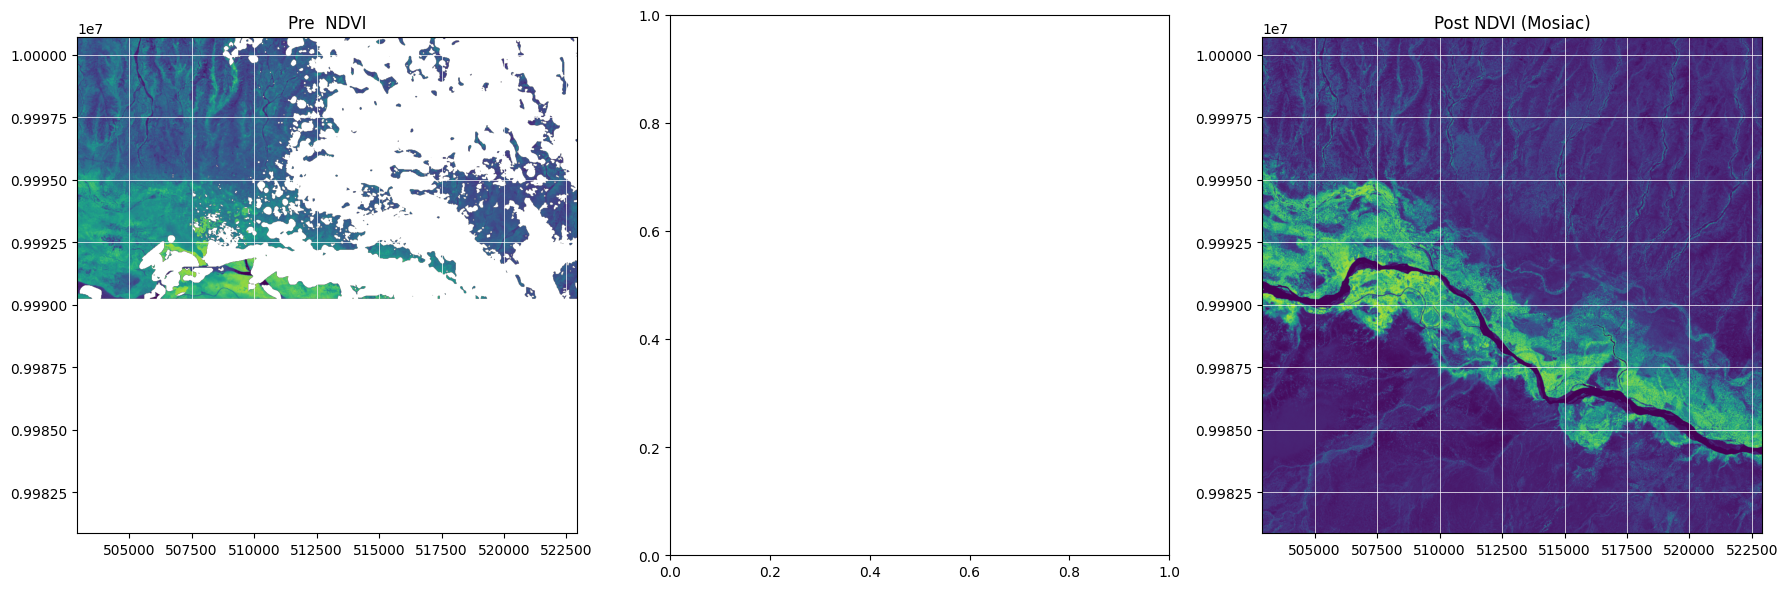

In [ ]:
#this code attempts to display the average, before and after NDVI of an area in one image
ndvi = rasterio.open("NDVI.tiff")
ndvi_mosiac = rasterio.open("Post_NDVI.tiff")

#creates 3 subplots of the NDVI values
f, axarr = plt.subplots(1, 3, dpi=100, figsize=(18, 6))
im = show(ndvi.read(1), vmin=0, vmax=1, transform=ndvi.transform, ax=axarr[0])
axarr[0].set_title("Pre  NDVI")

im = show(
    ndvi_mosiac.read(1), vmin=0, vmax=1, transform=ndvi_mosiac.transform, ax=axarr[2]
)
axarr[2].set_title("Post NDVI (Mosiac)")
for ax in axarr:
    ax.grid(True, which='both', color='white', linestyle='-', linewidth=0.5)
plt.tight_layout()

<ipython-input-18-e5a349ecc3d6>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


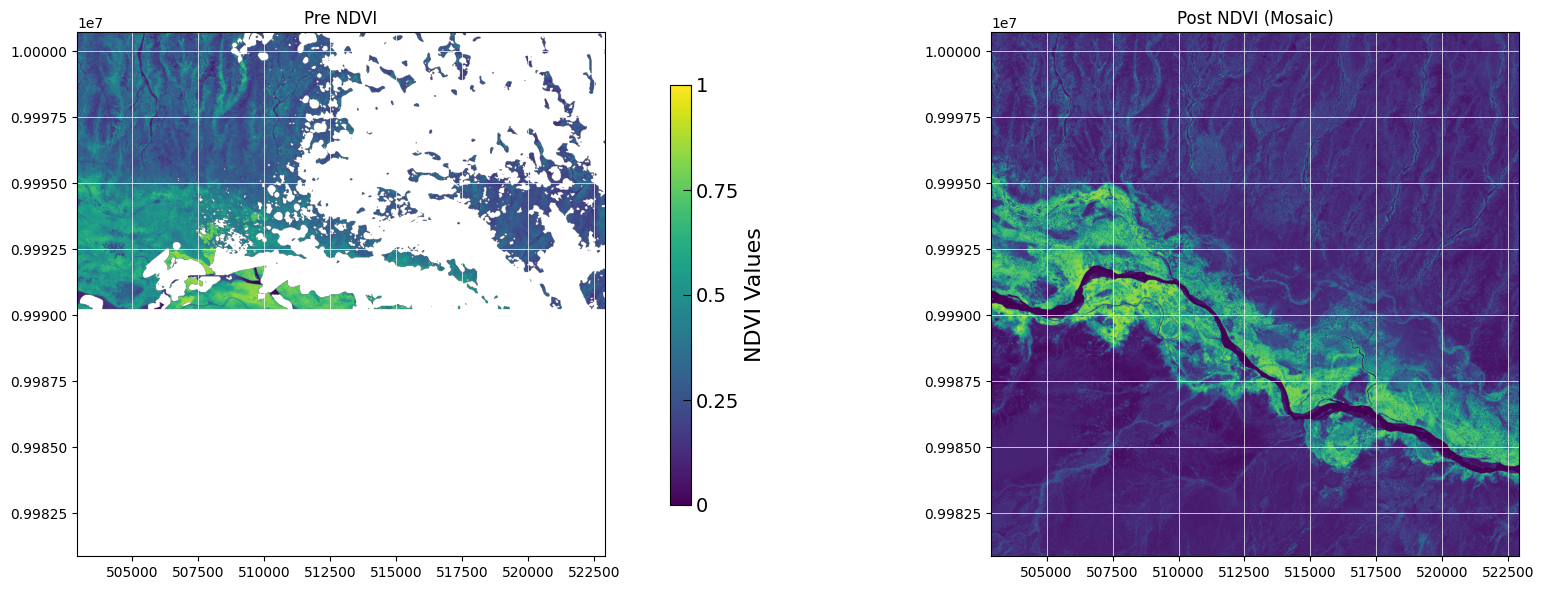

In [ ]:
#just displays the pre and post images, with a scale indicating what the NDVI values are in the middle

#import proper packages
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

# Open the NDVI files
ndvi = rasterio.open("NDVI.tiff")
ndvi_mosiac = rasterio.open("Post_NDVI.tiff")

# Create a plot with two subplots (1 row, 2 columns)
f, axarr = plt.subplots(1, 2, dpi=100, figsize=(18, 6))

# Plot the Pre-NDVI image
im1 = show(ndvi.read(1), vmin=0, vmax=1, transform=ndvi.transform, ax=axarr[0])
axarr[0].set_title("Pre NDVI")

# Plot the Post-NDVI (Mosaic) image
im2 = show(
    ndvi_mosiac.read(1), vmin=0, vmax=1, transform=ndvi_mosiac.transform, ax=axarr[1]
)
axarr[1].set_title("Post NDVI (Mosaic)")

# Add grid lines to all subplots
for ax in axarr:
    ax.grid(True, which='both', color='white', linestyle='-', linewidth=0.5)

# Adjust layout to allow space for the colorbar between the plots
plt.subplots_adjust(wspace=0.3)  # Increase horizontal spacing between the plots

# Add colorbar to show NDVI range for all images, positioned between the plots
cbar = f.colorbar(im1.get_images()[0], ax=axarr, orientation='vertical', fraction=0.05, pad=0.1)

# Set the labels and ticks for the colorbar based on NDVI values
cbar.set_label("NDVI Values", fontsize=16)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(["0", "0.25", "0.5", "0.75", "1"])

# Increase spacing of the ticks on the colorbar
cbar.ax.tick_params(labelsize=14, direction='in', length=6)  # Larger, more spaced-out ticks

# Adjust the colorbar position to move it a bit more to the right
cbar.ax.set_position([0.52, 0.15, 0.03, 0.7])  # Increase the x-position to move the colorbar right

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# this one identifies the bounding box into an interactive map which is them exported as an html
# can be manipulated to be of a different polygon?

#uses the folium package, a widely used python packages used for spatial and geospatial analysis
import folium
import math

# Center point (latitude, longitude)
center_lat = -0.083333
center_lon = 39.116

# Maximum size in meters (20 km x 20 km)
max_size_meters = 20000

# Conversion factors
meters_per_degree_lat = 111320  # Meters per degree of latitude
meters_per_degree_lon = 111320 * math.cos(math.radians(center_lat))  # Adjusted for the center latitude

# Calculate the size in degrees
lat_diff_deg = max_size_meters / meters_per_degree_lat
lon_diff_deg = max_size_meters / meters_per_degree_lon

# Calculate the bounding box coordinates
bounding_box = {
    "west": center_lon - (lon_diff_deg / 2),
    "south": center_lat - (lat_diff_deg / 2),
    "east": center_lon + (lon_diff_deg / 2),
    "north": center_lat + (lat_diff_deg / 2)
}

# Output the bounding box
print("Bounding Box Coordinates:")
print(f"West: {bounding_box['west']}")
print(f"South: {bounding_box['south']}")
print(f"East: {bounding_box['east']}")
print(f"North: {bounding_box['north']}")

#Create a map centered on the center point- this initializes the location on the map accessed by the folium package
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

#Add a bounding box as a rectangle on the map
folium.Rectangle(
    bounds=[(bounding_box["south"], bounding_box["west"]), (bounding_box["north"], bounding_box["east"])],
    color="blue",
    weight=2,
    fill=True,
    fill_color="blue",
    fill_opacity=0.2
).add_to(m)

#Save the map to an HTML file which can be opened
m.save("bounding_box_map.html")

# Now you can open the "bounding_box_map.html" in your browser to see the map with the bounding box overlay


Bounding Box Coordinates:
West: 39.02616878748726
South: -0.1731641174991017
East: 39.20583121251274
North: 0.006498117499101688


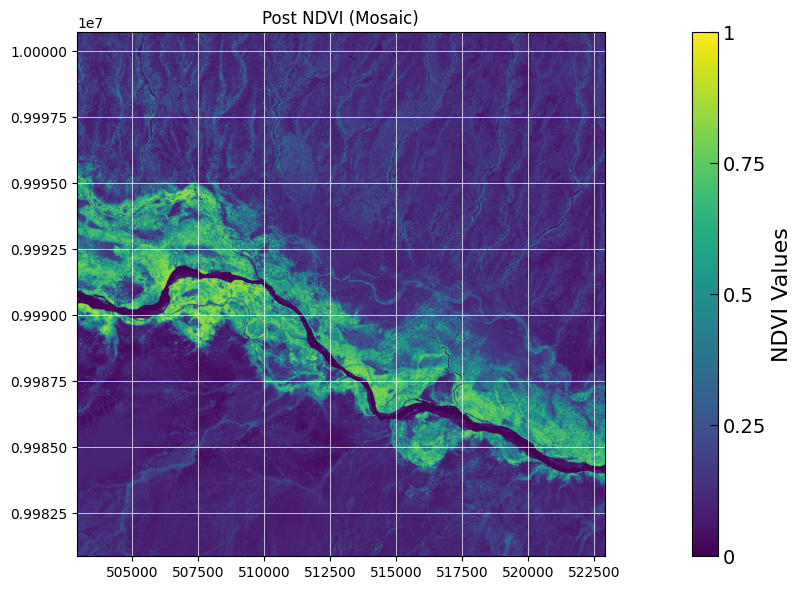

Post-NDVI image saved as post_ndvi_output.tiff


In [ ]:
#saving the NDVI as a tiff instead of png
#this tiff is then used as an overlay in the folium map which can display the NDVI over the existing street view map
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show

# Open the NDVI mosaic file
ndvi_mosiac = rasterio.open("Post_NDVI.tiff")

# Read the data and transform
ndvi_data = ndvi_mosiac.read(1)

# Create a plot (just one subplot for Post-NDVI)
f, ax = plt.subplots(1, 1, dpi=100, figsize=(9, 6))  # Single subplot for the Post-NDVI image

# Plot the Post image
im2 = show(
    ndvi_data, vmin=0, vmax=1, transform=ndvi_mosiac.transform, ax=ax
)
ax.set_title("Post NDVI (Mosaic)")

# Add grid lines
ax.grid(True, which='both', color='white', linestyle='-', linewidth=0.5)

# Add colorbar
cbar = f.colorbar(im2.get_images()[0], ax=ax, orientation='vertical', fraction=0.05, pad=0.1)

# Set the labels and ticks for the colorbar based on NDVI values
cbar.set_label("NDVI Values", fontsize=16)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(["0", "0.25", "0.5", "0.75", "1"])

# Increase spacing of the ticks on the colorbar
cbar.ax.tick_params(labelsize=14, direction='in', length=6)
# Adjust the colorbar position
cbar.ax.set_position([0.52, 0.15, 0.03, 0.7])

# Display the plot
plt.tight_layout()
plt.show()


# Define the output file name
output_tiff = "post_ndvi_output.tiff"

# Define the metadata for the output TIFF file
metadata = ndvi_mosiac.meta
metadata.update(
    dtype=rasterio.float32,  # Use the same data type as the input data
    count=1,                 # Single band
    compress='lzw'
)

# Create the new TIFF file and write the data
with rasterio.open(output_tiff, 'w', **metadata) as dst:
    dst.write(ndvi_data, 1)  # Write the data to the first band

print(f"Post-NDVI image saved as {output_tiff}")


In [ ]:
#one we want to use
#takes the tiff from the ndvi value, and then generates it as an overlay onto the map

#again uses the folium map feature
import folium
import numpy as np
import rasterio
from folium import raster_layers
from matplotlib import cm
from PIL import Image
import io
import tempfile

# Load the NDVI mosaic image
ndvi_mosiac = rasterio.open("Post_NDVI.tiff")

# Read the data and get the colormap
ndvi_data = ndvi_mosiac.read(1)

# Normalize NDVI data to 0-1 range
ndvi_normalized = np.clip(ndvi_data, 0, 1)

# Apply a colormap
cmap = cm.get_cmap('YlGn')
img_rgb = cmap(ndvi_normalized)[:, :, :3]  # Use only RGB channels

# Convert the RGB image to a PIL image
img_pil = Image.fromarray((img_rgb * 255).astype(np.uint8))

# Save the image as a temporary file
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp_file:
    tmp_file_path = tmp_file.name
    img_pil.save(tmp_file_path)

# Define your bounding box
{
      'north': 0.006498117499101688,
    'south': -0.1731641174991017,
    'west': 39.02616878748726,
    'east': 39.20583121251274
}

# Set up a folium map (using a center point, here assumed to be the center of your bounding box)
m = folium.Map(location=[(bounding_box['north'] + bounding_box['south']) / 2,
                         (bounding_box['west'] + bounding_box['east']) / 2], zoom_start=12)

# Create an image overlay using folium (using the temporary PNG file)
image_overlay = raster_layers.ImageOverlay(
    image=tmp_file_path,  # The path to the temporary image file
    bounds=[[bounding_box['south'], bounding_box['west']], [bounding_box['north'], bounding_box['east']]],
    opacity=0.6
)

# Add the image overlay to the map
image_overlay.add_to(m)

# Display the map
m.save("map_with_overlay.html")

#this html can be opened in a similar manner as the previous one, in this one you should see a NDVI image of the area specified
#zooming in and out allows you to look at the geographical location in respect to the rest of the world


<ipython-input-31-b0d1495757f0>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlGn')  # Choose your colormap


In [ ]:
#this next cell allows one to display the lat long coordinates on the NDVI image
import folium
import numpy as np
import rasterio
from folium import raster_layers
from matplotlib import cm
from PIL import Image
import io
import tempfile

#same code as above
# Load the NDVI mosaic image
ndvi_mosiac = rasterio.open("Post_NDVI.tiff")

# Read the data and get the colormap
ndvi_data = ndvi_mosiac.read(1)

# Normalize NDVI data to 0-1 range
ndvi_normalized = np.clip(ndvi_data, 0, 1)

# Apply a colormap
cmap = cm.get_cmap('YlGn')
img_rgb = cmap(ndvi_normalized)[:, :, :3]  # Use only RGB channels

# Convert the RGB image to a PIL image
img_pil = Image.fromarray((img_rgb * 255).astype(np.uint8))

# Save the image as a temporary file
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp_file:
    tmp_file_path = tmp_file.name
    img_pil.save(tmp_file_path)

# Define your bounding box (example coordinates)
bounding_box = {
    'north': 0.006498117499101688,
    'south': -0.1731641174991017,
    'west': 39.02616878748726,
    'east': 39.20583121251274
}

# Set up a folium map (using a center point, here assumed to be the center of your bounding box)
m = folium.Map(location=[(bounding_box['north'] + bounding_box['south']) / 2,
                         (bounding_box['west'] + bounding_box['east']) / 2], zoom_start=12)

# Create an image overlay using folium (using the temporary PNG file)
image_overlay = raster_layers.ImageOverlay(
    image=tmp_file_path,  # The path to the temporary image file
    bounds=[[bounding_box['south'], bounding_box['west']], [bounding_box['north'], bounding_box['east']]],
    opacity=0.6
)

# Add the image overlay to the map
image_overlay.add_to(m)

# Add latitude/longitude popup (click on the map to see coordinates)
folium.LatLngPopup().add_to(m)

# Display the map
m.save("map_with_overlay_and_latlng.html")


<ipython-input-22-5f9b672ab5be>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlGn')  # Choose your colormap
